# Breaking workflows 
Applying MS false peptide match logic to my workflows (not really, but that was the inspiration) to show that, despite the fact that a high number of citations is the best predictor of highly rated workflow, it does not contain any co-usage information and is therefore not a good metric. 

In [2]:
import json
import sys
import os
import matplotlib.pyplot as plt 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import nest_asyncio
nest_asyncio.apply()
import asyncio
import json
import pubmetric.network as nw
from scipy.stats import ttest_rel
import numpy as np 
import pubmetric.metrics as met
from pubmetric import pckg_dev as dev
from scipy.stats import ttest_ind
from scipy.stats import binom

from style import palette


The aim is to infer functional relationships based on citation patterns. The underlying assumption is that tools used together in a workflow are likely to be cited together in research papers. Additionally, tools with similar functions may also frequently appear together in citations. The most straightforward metric for evaluating a functional workflow is by identifying which tool has the most citations.

I plan to create a reverse dataset because I believe that examining the number of co-citations of tools provides more insight into their co-usage. The correlation between citation counts and high ratings may be influenced by confounding factors, such as the frequent use of highly cited tools. However, this does not necessarily indicate that these tools are often used together.

To test this, I will compile a list of the top 100 most cited tools and then disrupt well-performing workflows by randomly replacing one tool with one from this top 100 list. This approach aims to demonstrate that a good metric should meet certain criteria: 

1. If all connections (edges) represent viable, functional, and actually used tool combinations, the metric should yield a high score.
2. If an edge is replaced with a better one, the metric score should increase, and vice versa.

I hope to show that the connectivity between tools in a graph more accurately reflects the true functional relationships between tools, although the rated dataset correlates more just to the number of citations a tool has.

In [3]:
path_to_data = '../out/out_20240814142510'
loaded_graph = asyncio.run(nw.create_network(inpath=path_to_data, load_graph=True))

2024-08-26 19:11:33 - Loading graph from ../out/out_20240814142510/graph.pkl.
2024-08-26 19:11:33 - Graph loaded from ../out/out_20240814142510/graph.pkl.
2024-08-26 19:11:33 - Complete data download and graph creation took 0:00:00.013268


In [ ]:
citation_counts = {tool['pmid']: tool['nr_citations'] for tool in loaded_graph.vs}
citation_values = list(citation_counts.values())

sorted_citation_counts = dict(sorted(citation_counts.items(), key=lambda item: item[1], reverse=True))
top_citation_counts = list(sorted_citation_counts.values())[0:100]
top_citation_tools = list(sorted_citation_counts.keys())[0:100]

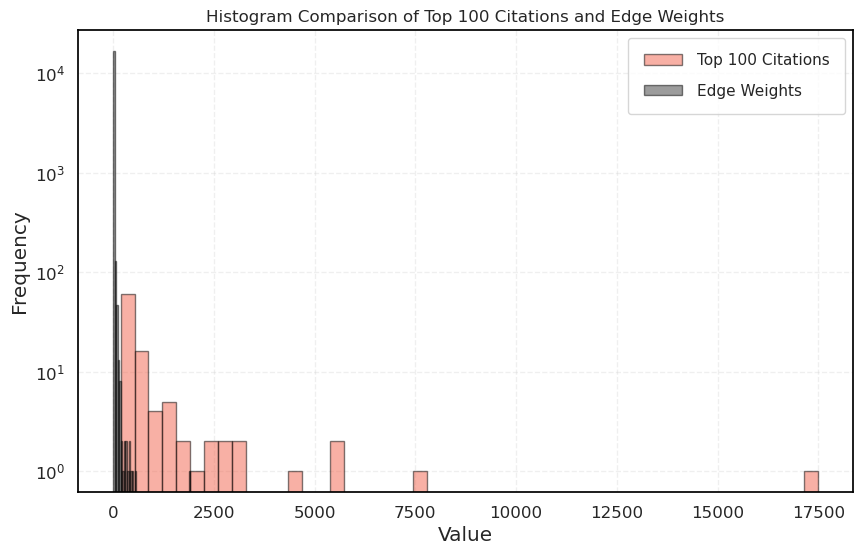

In [6]:
edge_weights = loaded_graph.es['weight']

# Plot histograms for top 100 citation counts and edge weights to ensure they are smaller than the citation counts 
plt.hist(top_citation_counts, bins=50, alpha=0.5, label='Top 100 Citations', edgecolor='black')
plt.hist(edge_weights, bins=50, alpha=0.5, label='Edge Weights', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram Comparison of Top 100 Citations and Edge Weights')
plt.legend(loc='upper right')
plt.show()


16837 1120


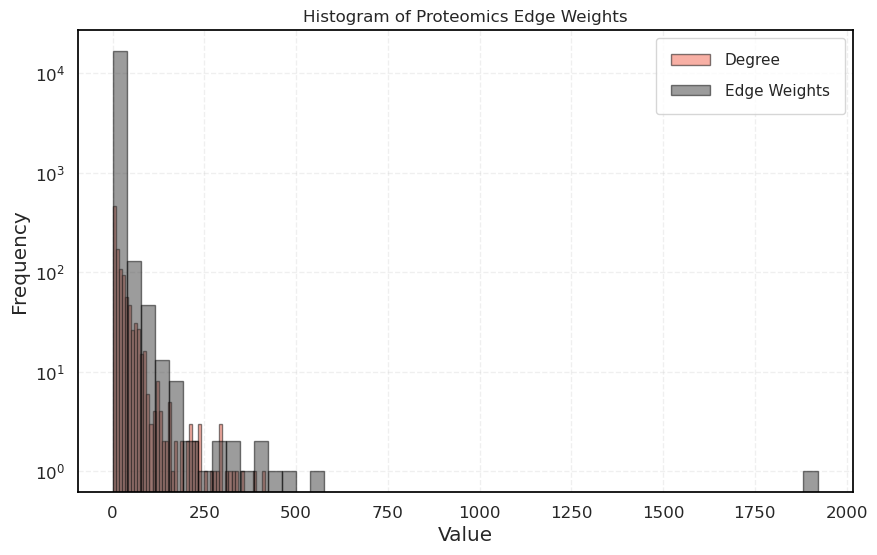

In [7]:
edge_weights = loaded_graph.es['weight']
edge_degree = loaded_graph.vs.degree()

print(len(edge_weights), len(edge_degree))
plt.hist(edge_degree, bins=50, alpha=0.5, label='Degree', edgecolor='black')
plt.hist(edge_weights, bins=50, alpha=0.5, label='Edge Weights', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Proteomics Edge Weights')
plt.legend(loc='upper right')
plt.show()


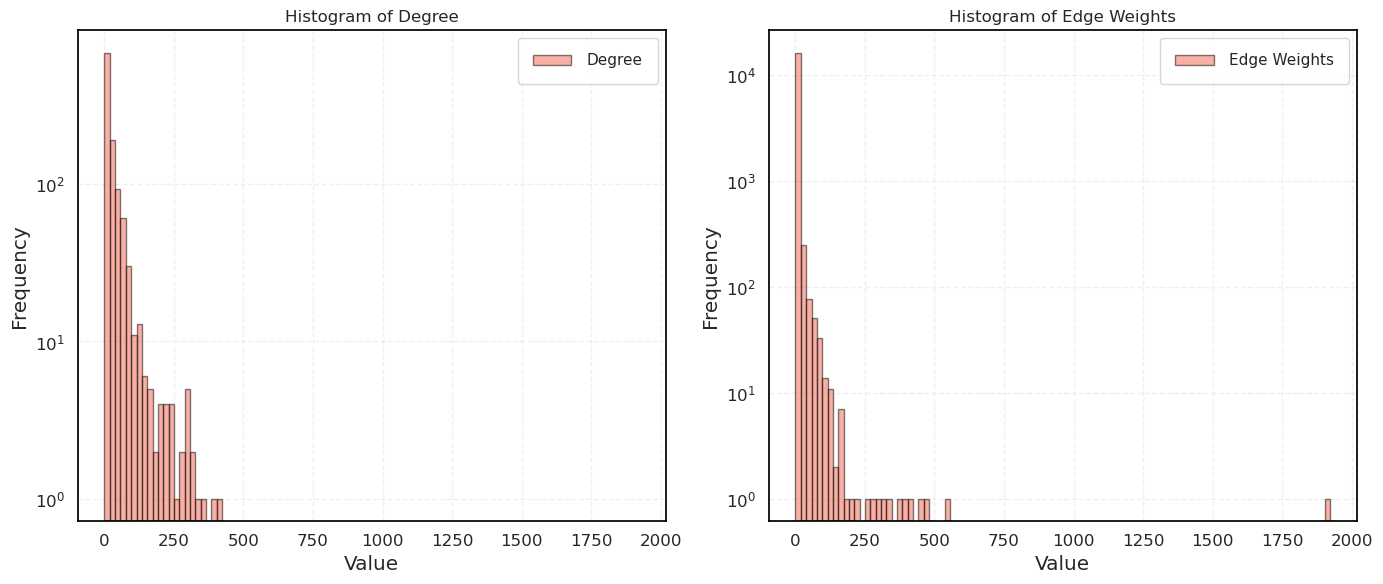

In [8]:
min_value = min(min(edge_weights), min(edge_degree))
max_value = max(max(edge_weights), max(edge_degree))

bin_edges = np.linspace(min_value, max_value, 101)  # 100 bins

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

ax1.hist(edge_degree, bins=bin_edges, alpha=0.5, label='Degree', edgecolor='black')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_yscale('log')
ax1.set_title('Histogram of Degree')
ax1.legend(loc='upper right')

ax2.hist(edge_weights, bins=bin_edges, alpha=0.5, label='Edge Weights', edgecolor='black')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.set_yscale('log')
ax2.set_title('Histogram of Edge Weights')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### breaking workflows


In [9]:
with open('../data/train_rated.json', 'r') as f:
    rated_workflows = json.load(f)
print(len(rated_workflows))
highly_rated_workflows = [workflow["pmid_workflow"] for workflow in rated_workflows if workflow['ratingAvg'] >= 2] # this means that at least one of them gave it a two or higher
print(len(highly_rated_workflows))


250
50


# Evaluating metric ability of capturing workflow degradation 

In [10]:
original_complete_scores = []
original_workflow_scores = []
original_citation_scores = []
broken_complete_scores = []
broken_workflow_scores = []
broken_citation_scores = []

for workflow in highly_rated_workflows:
    workflow = dev.convert_to_tuples(workflow)
    if not workflow:
        continue
    # Original scores:
    og_complete_score = met.complete_average(loaded_graph, workflow)
    og_workflow_score = met.workflow_average(loaded_graph, workflow)
    og_cite_score = met.median_citations(loaded_graph, workflow)

    broken_workflow = dev.break_workflow(workflow, top_citation_counts)

    # Scores after breaking the workflow
    broken_complete_score = met.complete_average(loaded_graph, broken_workflow)
    broken_workflow_score = met.workflow_average(loaded_graph, broken_workflow)
    broken_cite_score = met.median_citations(loaded_graph, broken_workflow)

    original_complete_scores.append(og_complete_score)
    original_workflow_scores.append(og_workflow_score)
    original_citation_scores.append(og_cite_score)
    broken_complete_scores.append(broken_complete_score)
    broken_workflow_scores.append(broken_workflow_score)
    broken_citation_scores.append(broken_cite_score)


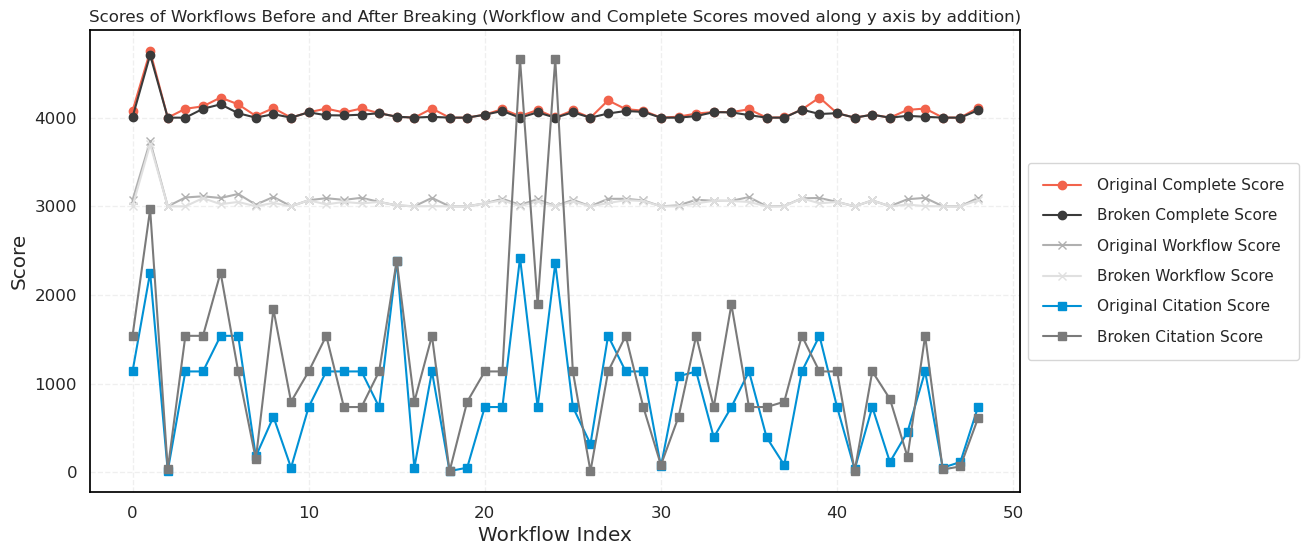

In [12]:

workflow_scaling_nr_w = 3000 
workflow_scaling_nr_c = 4000 

plt.figure(figsize=(12, 6)) 

plt.plot([score + workflow_scaling_nr_c for score in original_complete_scores], 
         label='Original Complete Score', marker='o', color=palette[0])
plt.plot([score + workflow_scaling_nr_c for score in broken_complete_scores], 
         label='Broken Complete Score', marker='o', color=palette[1])
plt.plot([score + workflow_scaling_nr_w for score in original_workflow_scores], 
         label='Original Workflow Score', marker='x', color=palette[2])
plt.plot([score + workflow_scaling_nr_w for score in broken_workflow_scores], 
         label='Broken Workflow Score', marker='x', color=palette[3])
plt.plot(original_citation_scores, 
         label='Original Citation Score', marker='s', color=palette[4])
plt.plot(broken_citation_scores, 
         label='Broken Citation Score', marker='s', color=palette[5])

plt.xlabel('Workflow Index')
plt.ylabel('Score')
plt.title('Scores of Workflows Before and After Breaking (Workflow and Complete Scores moved along y axis by addition)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.grid(True)
plt.show()


In [13]:
alpha = 0.05/3

# Complete Scores
t_stat, p_value = ttest_rel(original_complete_scores, broken_complete_scores)
print("Complete Scores:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value:{p_value:.2e}")
if p_value < alpha and np.mean(original_complete_scores) > np.mean(broken_complete_scores):
    print("It is probable that the original complete scores are significantly higher than the broken complete scores.")
else:
    print("There is no significant evidence that the original complete scores are higher than the broken complete scores.")

# Workflow Scores
t_stat, p_value = ttest_rel(original_workflow_scores, broken_workflow_scores)
print("\nWorkflow Scores:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value:{p_value:.2e}")
if p_value < alpha and np.mean(original_workflow_scores) > np.mean(broken_workflow_scores):
    print("It is probable that the original workflow scores are significantly higher than the broken workflow scores.")
else:
    print("There is no significant evidence that the original workflow scores are higher than the broken workflow scores.")

# median citation
t_stat, p_value = ttest_rel(original_citation_scores, broken_citation_scores)
print("\nCitation Scores:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value:{p_value:.2e}")
if p_value < alpha and np.mean(original_citation_scores) > np.mean(broken_citation_scores):
    print("It is probable that the original citation scores are significantly higher than the broken citation scores.")
else:
    print("There is no significant evidence that the original citation scores are higher than the broken citation scores.")

t_stat, p_value = ttest_rel(broken_citation_scores, original_citation_scores)
print("\nCitation Scores:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value:{p_value:.2e}")
if p_value < alpha and np.mean(original_citation_scores) > np.mean(broken_citation_scores):
    print("It is probable that the original citation scores are significantly higher than the broken citation scores.")
else:
    print("There is no significant evidence that the original citation scores are higher than the broken citation scores.")



Complete Scores:
t-statistic: 5.128
p-value:5.20e-06
It is probable that the original complete scores are significantly higher than the broken complete scores.

Workflow Scores:
t-statistic: 5.551
p-value:1.21e-06
It is probable that the original workflow scores are significantly higher than the broken workflow scores.

Citation Scores:
t-statistic: -3.869
p-value:3.30e-04
There is no significant evidence that the original citation scores are higher than the broken citation scores.

Citation Scores:
t-statistic: 3.869
p-value:3.30e-04
There is no significant evidence that the original citation scores are higher than the broken citation scores.


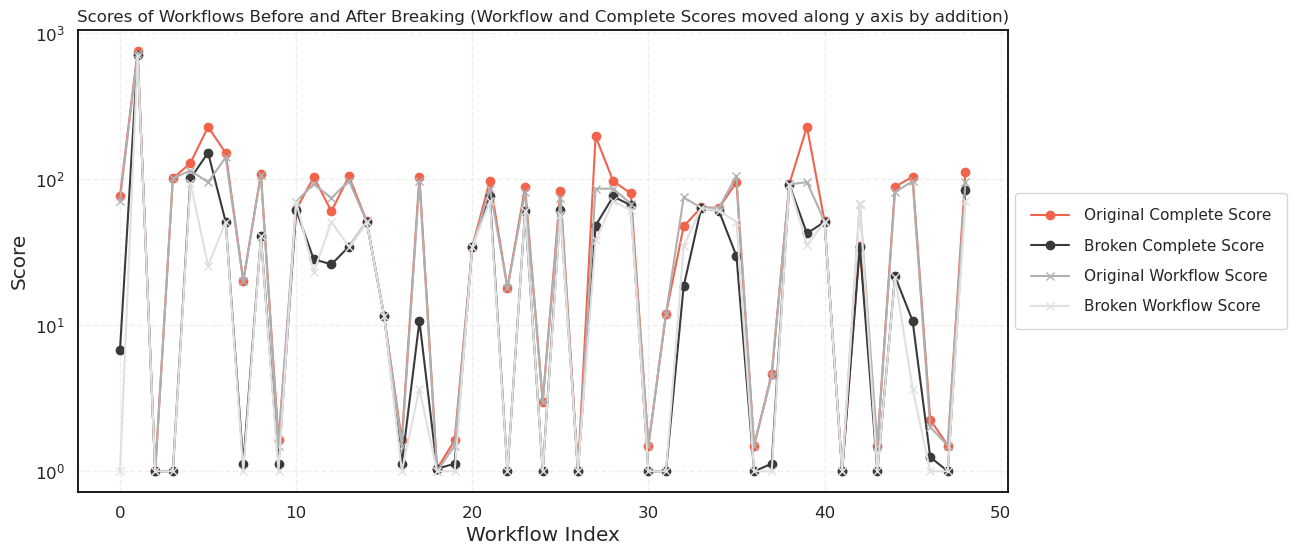

In [14]:

workflow_scaling_nr_w = 1 
workflow_scaling_nr_c = 1 

plt.figure(figsize=(12, 6)) 

plt.plot([score + workflow_scaling_nr_w for score in original_complete_scores], 
         label='Original Complete Score', marker='o', color=palette[0])
plt.plot([score + workflow_scaling_nr_c for score in broken_complete_scores], 
         label='Broken Complete Score', marker='o', color=palette[1])
plt.plot([score + workflow_scaling_nr_w for score in original_workflow_scores], 
         label='Original Workflow Score', marker='x', color=palette[2])
plt.plot([score + workflow_scaling_nr_c for score in broken_workflow_scores], 
         label='Broken Workflow Score', marker='x', color=palette[3])
plt.xlabel('Workflow Index')
plt.ylabel('Score')
plt.yscale('log')
plt.title('Scores of Workflows Before and After Breaking (Workflow and Complete Scores moved along y axis by addition)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.grid(True)
plt.show()


We had the hypothesis that complete average would suffer harder from inserts of new random tools while bifferting insertion of tools seen before in a similar context than complete.

In [16]:
# Filtering out instances where either original complete or workflow score is 0
filtered_data = [(b_complete, o_complete, b_workflow, o_workflow)
                 for b_complete, o_complete, b_workflow, o_workflow in zip(broken_complete_scores, original_complete_scores, broken_workflow_scores, original_workflow_scores)
                 if o_complete != 0 and o_workflow != 0]

complete_difference = [b_complete / o_complete for b_complete, o_complete, _, _ in filtered_data]
workflow_difference = [b_workflow / o_workflow for _, _, b_workflow, o_workflow in filtered_data]
print(len(complete_difference))

45


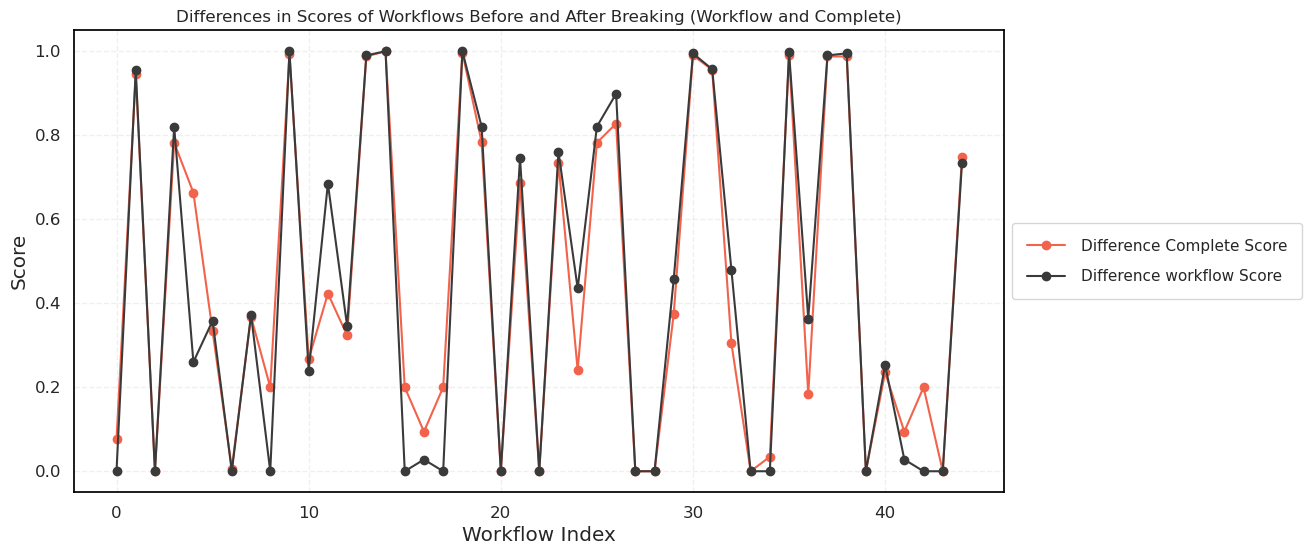

In [17]:

workflow_scaling_nr_w = 1 
workflow_scaling_nr_c = 1 

plt.figure(figsize=(12, 6)) 

plt.plot(complete_difference, 
         label='Difference Complete Score', marker='o', color=palette[0])
plt.plot(workflow_difference, 
         label='Difference workflow Score', marker='o', color=palette[1])

plt.xlabel('Workflow Index')
plt.ylabel('Score')
# plt.yscale('log')
plt.title('Differences in Scores of Workflows Before and After Breaking (Workflow and Complete)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.grid(True)
plt.show()


In [18]:

complete_difference = np.array(complete_difference)
workflow_difference = np.array(workflow_difference)

# two-sample t-test
t_stat, p_value = ttest_ind(complete_difference, workflow_difference, alternative='less')
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("The differences in Complete Average are significantly smaller than those in Workflow Average.")
else:
    print("There is no significant difference between the Complete Average and Workflow Average differences.")


T-statistic: 0.0571
P-value: 0.5227
There is no significant difference between the Complete Average and Workflow Average differences.


# TOOL - LEVEL METRIC

In [19]:
highlish_rated_workflows = [workflow["pmid_workflow"] for workflow in rated_workflows if workflow['ratingAvg'] > 1] # this means that at least one of them gave it a two or higher
print(len(highlish_rated_workflows))

78


In [20]:
def dictyfy(workflow):
    workflow_dict = {}
    unique_ids = {item for tup in workflow for item in tup} 
    id_dict = {str(pmid): pmid for i, pmid in enumerate(unique_ids)}
    workflow_dict['steps'] = id_dict
    workflow_dict['edges'] = [(str(s), str(t)) for s,t in workflow]
    workflow_dict['pmid_edges'] = workflow
    
    return workflow_dict

In [ ]:
highlish_dict = []
for wf in highlish_rated_workflows:
    highlish_dict.append(dictyfy(wf))

print(highlish_dict)

highlish_dict = [wf for wf in highlish_dict if len(wf['steps'])>2]

3.943661971830986
71


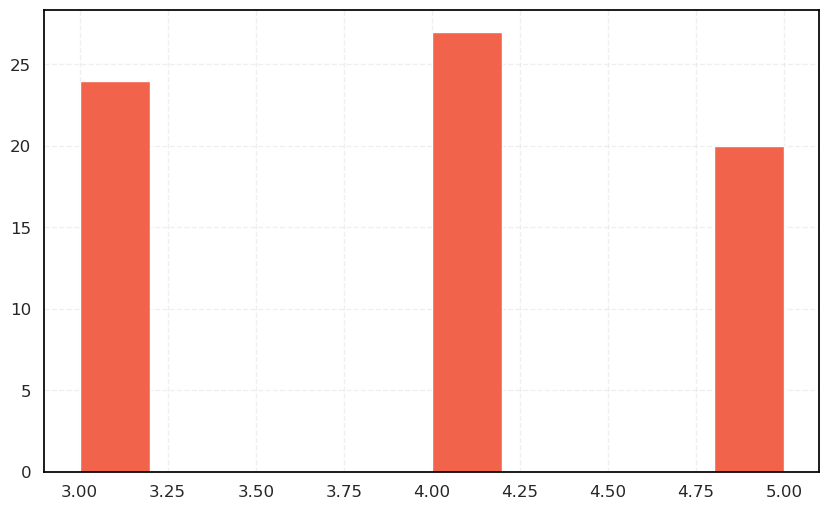

In [25]:
print(np.mean([len(wf['steps']) for wf in highlish_dict]))
plt.hist([len(wf['steps']) for wf in highlish_dict])
print(len(highlish_dict))


hypothesis: tool level metric should be able to identify the odd one out- the randomly inserted tool. 

In [22]:
def test_identification_accuracy():
    tool_scores = []
    random_scores = []

    for workflow in highlish_rated_workflows:
        workflow = dev.convert_to_tuples(workflow)
        if not workflow:
            continue

        broken_workflow = dev.break_workflow(workflow, top_citation_tools)

        unique_ids = {item for tup in workflow for item in tup if item is not None}

        random_unique_ids = {item for tup in broken_workflow for item in tup if item is not None}
        difference_ids = random_unique_ids - unique_ids
        difference_ids_list = list(difference_ids)
        if not difference_ids_list:
            continue

        # Scores after breaking the workflow
        broken_worfklow_dict = dictyfy(broken_workflow)
        broken_tool_score = met.tool_average_sum(loaded_graph, broken_worfklow_dict)
        key_with_lowest_value = min(broken_tool_score, key=broken_tool_score.get)
        tool_scores.append(key_with_lowest_value == difference_ids_list[0])
        random_scores.append(np.random.choice(list(broken_worfklow_dict['steps'].values())) == difference_ids_list[0])


    return  (len([t for t in tool_scores if t == True]), len([t for t in random_scores if t == True])) 

In [23]:
id_acc =[]
for i in range(0, 1000):
    id_acc.append(test_identification_accuracy())

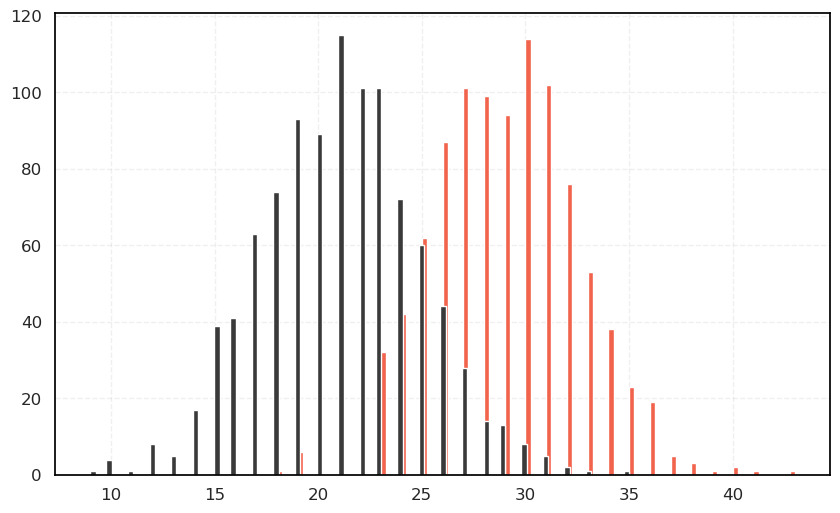

In [10]:

metric_scores = [t[0] for t in id_acc]
random_scores = [t[1] for t in id_acc]


plt.hist(metric_scores, bins=100)
plt.hist(random_scores, bins=100)
plt.show()

Metric Scores - Mean: 28.7660, Std Dev: 3.6713
Random Scores - Mean: 21.0340, Std Dev: 3.8178
T-statistic: 45.7645, P-value: 1.9827e-247


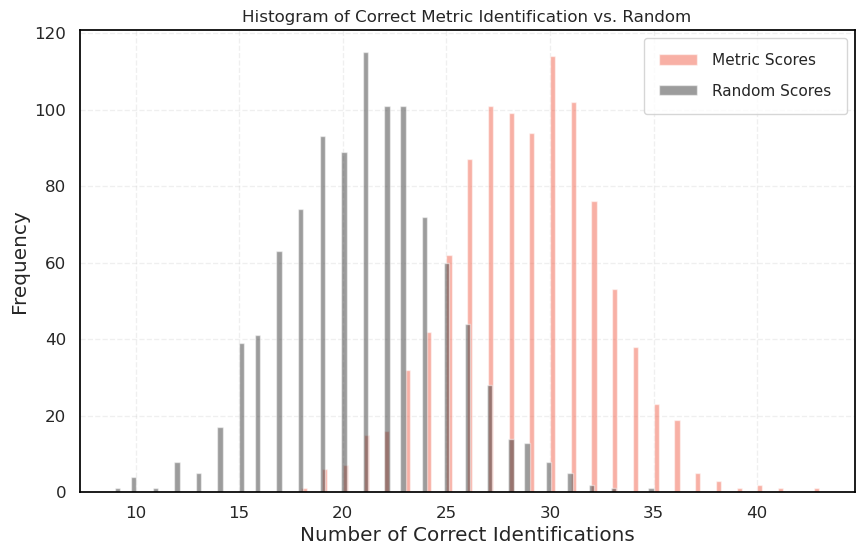

In [24]:

mean_metric = np.mean(metric_scores)
std_metric = np.std(metric_scores, ddof=1)
mean_random = np.mean(random_scores)
std_random = np.std(random_scores, ddof=1)

print(f"Metric Scores - Mean: {mean_metric:.4f}, Std Dev: {std_metric:.4f}")
print(f"Random Scores - Mean: {mean_random:.4f}, Std Dev: {std_random:.4f}")

t_statistic, p_value = ttest_rel(metric_scores, random_scores)
print(f"T-statistic: {t_statistic:.4f}, P-value: {p_value:.4e}")

plt.hist(metric_scores, bins=100, alpha=0.5, label='Metric Scores')
plt.hist(random_scores, bins=100, alpha=0.5, label='Random Scores')
plt.legend(loc='upper right')
plt.xlabel('Number of Correct Identifications')
plt.ylabel('Frequency')
plt.title('Histogram of Correct Metric Identification vs. Random')
plt.show()


In [ ]:
# how many times metric better than random 
better_count = np.sum(np.array(metric_scores) > np.array(random_scores))
proportion_better = better_count / len(metric_scores)

Im tired so the varaible names are stolen from other notebook

In [54]:
ape_tools = set([step for tool in highlish_dict for step in tool['steps'].values()])
ape_edges = set([(step[0],step[1]) for tool in highlish_dict for step in tool['pmid_edges']])
print(len(ape_tools))
print(len(ape_edges))
ape_tools = np.unique([step for workflow in highly_rated_workflows for step in workflow if None not in step])
ape_edges = set([(step[0], step[1]) for workflow in highly_rated_workflows for step in workflow if None not in step])
print(len(ape_tools))
print(len(ape_edges))

22
57
18
33
